# Neural Style Transfer

In [53]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import random
import cv2
import matplotlib.pyplot as plt

import copy

## Style transfer

The Neural Style Transfer is an algorithm that takes as input a content-image and a style-image and returns the content of the content-image as if it was ‘painted’ using the artistic style of the style-image.

For a style image I will use "The Jungle", 1942-43. <it>The Jungle</it> is a painting from the Cuban artist Wifredo Lam.

In [87]:
PATH = Path("/data2/yinterian/style-transfer/")

In [88]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

(400, 383, 3)

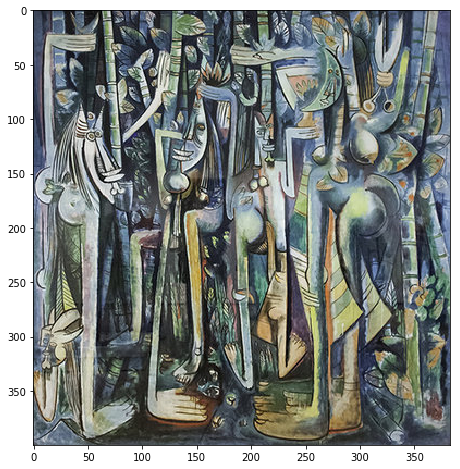

In [89]:
path = PATH/"lam.jpg"
im1 = read_image(path)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(im1)
im1.shape

To get this image: <br>
`wget https://ka-perseus-images.s3.amazonaws.com/13622ed51ffa88abd6604277fb0d8ab610fbe8e7.jpg
--2018-06-14 09:46:15--  https://ka-perseus-images.s3.amazonaws.com/13622ed51ffa88abd6604277fb0d8ab610fbe8e7.jpg` <br>
`mv 13622ed51ffa88abd6604277fb0d8ab610fbe8e7.jpg lam.jpg`

Here is my content image. This a picture of my son. You can use your favorite content image.

(4032, 3024, 3)

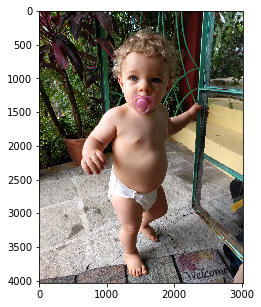

In [90]:
path2 = PATH/"ari.jpg"
im2 = read_image(path2)
fig2 = plt.figure(figsize = (5,5)) 
plt.imshow(im2)
im2.shape

## Preprocessing
We need style and content images of the same size.

In [91]:
# resizing the content image
r = im2.shape[0]/im2.shape[1]
x_sz = 383
y_sz = int(r*x_sz)
print(y_sz, x_sz)

510 383


In [92]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

(383, 383, 3)

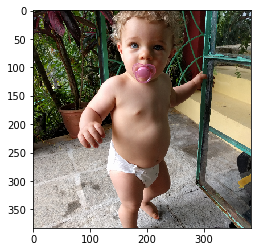

In [93]:
im2 = cv2.resize(im2, (x_sz, y_sz))
im2 = center_crop(im2)
plt.imshow(im2)
im2.shape

In [94]:
im1 = center_crop(im1)
im1.shape

(383, 383, 3)

In [62]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [124]:
def denormalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return im*imagenet_stats[1] + imagenet_stats[0]

In [86]:
def transform_images(im):
    """ Transform images to be ready for vgg"""
    im = normalize(im/255)
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [95]:
im_style = transform_images(im1)
im_content = transform_images(im2)

In [96]:
im_style.shape

torch.Size([1, 3, 383, 383])

## Prepare vgg16

In [65]:
# get vgg16 model
vgg = models.vgg16(True).cuda().eval()

In [66]:
# freezing parameters
for param in vgg.parameters():
    param.requires_grad = False

In [67]:
list(vgg.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (17): Conv2d(256, 512, kernel_size=(3, 3), strid

In [68]:
layers = list(vgg.children())[0]
m_vgg = nn.Sequential(*layers)

## Content optimization

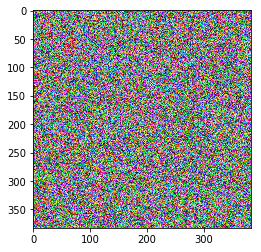

In [97]:
# start with a random image
opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
plt.imshow(opt_img)

In [99]:
im_opt = transform_images(opt_img*255)
im_opt.shape

torch.Size([1, 3, 383, 383])

In [101]:
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
im_opt.requires_grad=True

In [113]:
# Making the image pixes the parameters of the model
optimizer = optim.LBFGS([im_opt], lr=0.001)

In [104]:
# the target here is the output of the content image
# after vgg16
targ_v = m_vgg(im_content)
targ_v.shape

torch.Size([1, 512, 11, 11])

In [106]:
F.mse_loss(m_vgg(im_opt), targ_v)

tensor(1.9193, device='cuda:0')

In [133]:
# for optim.LBFGS we have to define a closure function
def train_image(optimizer, targ_v, im_opt, iters):
    for i in range(iters):
        def closure():
            optimizer.zero_grad()
            loss = F.mse_loss(m_vgg(im_opt), targ_v)
            loss.backward()
            return loss
        optimizer.step(closure)
        print((F.mse_loss(m_vgg(im_opt), targ_v)).item())

In [131]:
train_image(optimizer, targ_v, im_opt, 10)

tensor(1.00000e-02 *
       7.5652, device='cuda:0')
tensor(1.00000e-02 *
       7.5652, device='cuda:0')
tensor(1.00000e-02 *
       7.5652, device='cuda:0')
tensor(1.00000e-02 *
       7.5652, device='cuda:0')
tensor(1.00000e-02 *
       7.5652, device='cuda:0')
tensor(1.00000e-02 *
       7.5652, device='cuda:0')
tensor(1.00000e-02 *
       7.5652, device='cuda:0')
tensor(1.00000e-02 *
       7.5652, device='cuda:0')
tensor(1.00000e-02 *
       7.5652, device='cuda:0')
tensor(1.00000e-02 *
       7.5652, device='cuda:0')


In [116]:
x = im_opt.cpu().detach().numpy()

In [118]:
x = x[0]
x.shape

(3, 383, 383)

In [121]:
x = np.rollaxis(x,0,3)

In [125]:
x = denormalize(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


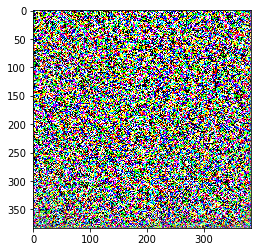

In [126]:
plt.imshow(x)

## Style Optimization

In [18]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [19]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [20]:
cnn = models.vgg19(pretrained=True).features.cuda().eval()

In [22]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    
    model = nn.Sequential()
    
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [23]:
input_img = im_content.clone()

In [24]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [30]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img,
                                                                     content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [31]:
output = run_style_transfer(cnn, im_content, im_style, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..


RuntimeError: expected stride to be a single integer value or a list of 1 values to match the convolution dimensions, but got stride=[1, 1]

## Style transfer

# References
This notebook is based on this [pytorch tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html), this [fast.ai notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/style-transfer.ipynb) and on this [paper](https://arxiv.org/pdf/1508.06576.pdf).